In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [43]:
#load data
df_raw = pd.read_csv('Weekly_Data.csv')

#reduce number of columns
df_raw = df_raw[['Cat_id', 'Season', 'Total', 'propActive',
       'propLying', 'propSitting', 'propStanding', 'propGrooming',
       'propLittering', 'propEating', 'propScratching', 'Cat_Age', 'Cat_Sex',
       'BW', 'BCS', 'BCS_ord', 'Housing', 'Area', 'Diet', 'Coat', 'Owner',
       'Owner_Age', 'Children', 'Cat1', 'Cat2', 'Dog' ]]

#prepare
for column in df_raw[['propActive','propLying', 'propSitting', 'propStanding', 'propGrooming',
       'propLittering', 'propEating', 'propScratching']]:
    df_raw[column] = [round(i,3)*100 for i in df_raw[column]]

#caculate total 'laziness' = time lying or sitting
df_raw["propLazy"] = df_raw[['propLying', 'propSitting']].sum(axis=1)

#get top3 poses
def get_nth_largest(row, n):
    sorted_row = row.dropna().sort_values(ascending=False)
    if len(sorted_row) >= n:
        return pd.Series({
            f"pose{n}_value": sorted_row.iloc[n - 1],
            f"pose{n}_column": sorted_row.index[n - 1]
        })
    else:
        return pd.Series({
            f"pose{n}_value": np.nan,
            f"pose{n}_column": None
        })

columns = ['propSitting','propLying','propStanding', 'propActive',
           'propGrooming','propLittering', 'propEating',
           'propScratching']

df_raw[["pose1_value", "pose1"]] =  df_raw[columns].apply(
    lambda row: get_nth_largest(row, 1), axis=1)
df_raw[["pose2_value", "pose2"]] =  df_raw[columns].apply(
    lambda row: get_nth_largest(row, 2), axis=1)
df_raw[["pose3_value", "pose3"]] =  df_raw[columns].apply(
    lambda row: get_nth_largest(row, 3), axis=1)
df_raw["pose_other_value"] = 100 - df_raw[["pose1_value", "pose3_value", "pose3_value"]].sum(axis=1)

df_raw.head()

,Cat_id,Season,Total,propActive,propLying,propSitting,propStanding,propGrooming,propLittering,propEating,...,Cat2,Dog,propLazy,pose1_value,pose1,pose2_value,pose2,pose3_value,pose3,pose_other_value
0,Cat1,Summer,604801,4.5,18.0,46.5,15.2,11.0,0.0,4.6,...,Single,Yes,64.5,46.5,propSitting,18.0,propLying,15.2,propStanding,23.1
1,Cat10,Summer,604801,5.4,36.2,35.5,8.0,8.5,0.1,6.1,...,Single,Yes,71.7,36.2,propLying,35.5,propSitting,8.5,propGrooming,46.8
2,Cat11,Summer,604801,5.6,21.6,57.2,8.4,5.6,0.1,1.4,...,Multi,No,78.8,57.2,propSitting,21.6,propLying,8.4,propStanding,26.0
3,Cat12,Summer,604801,4.2,32.2,47.3,8.5,4.9,0.0,2.8,...,Multi,No,79.5,47.3,propSitting,32.2,propLying,8.5,propStanding,35.7
4,Cat13,Summer,604801,2.4,45.4,23.9,17.4,2.9,0.0,8.0,...,Single,Yes,69.3,45.4,propLying,23.9,propSitting,17.4,propStanding,19.8


In [ ]:
#get aggregates by cat
df = df_raw.groupby("Cat_id").agg({'propActive':"mean", 'propLying':"mean", 'propSitting':"mean",
       'propStanding':"mean", 'propGrooming':"mean", 'propLittering':"mean", 'propEating':"mean",
       'propScratching':"mean", 'Cat_Age':"first", 'Cat_Sex':"first", 'BW':"first", 'BCS':"first", 'BCS_ord':"first",
       'Housing':"first", 'Area':"first", 'Diet':"first", 'Coat':"first", 'Owner':"first", 'Owner_Age':"first", 'Children':"first",
       'Cat1':"first", 'Cat2':"first", 'Dog':"first",
}).reset_index()

#top 3 poses
df[["pose1_value", "pose1"]] =  df[columns].apply(
    lambda row: get_nth_largest(row, 1), axis=1)
df[["pose2_value", "pose2"]] =  df[columns].apply(
    lambda row: get_nth_largest(row, 2), axis=1)
df[["pose3_value", "pose3"]] =  df[columns].apply(
    lambda row: get_nth_largest(row, 3), axis=1)
df["pose_other_value"] = 100 - df[["pose1_value", "pose3_value", "pose3_value"]].sum(axis=1)

#caculate total 'laziness' = time lying or sitting
df["propLazy"] = df[['propLying', 'propSitting']].sum(axis=1)

#merge summer and winter data
df = pd.merge(df, 
              df_raw[df_raw["Season"]=="Summer"][["Cat_id", "propLazy",'pose1_value', 'pose1',
                                                   'pose2_value', 'pose2', 'pose3_value', 'pose3', 
                                                   "pose_other_value"]],
              how="left", suffixes=["", "_summer"],
              left_on="Cat_id", right_on="Cat_id")

df = pd.merge(df, 
              df_raw[df_raw["Season"]=="Winter"][["Cat_id", "propLazy",'pose1_value', 'pose1', 
                                                  'pose2_value', 'pose2', 'pose3_value', 'pose3',
                                                    "pose_other_value"]],
              how="left", suffixes=["", "_winter"],
              left_on="Cat_id", right_on="Cat_id")

#more lazy in summer or winter
df["lazy_season"] = df[["propLazy_summer", "propLazy_winter"]].idxmax(axis=1).str.split("_").str[1]
df["lazy_diff"] = (df["propLazy_summer"] - df["propLazy_winter"]).abs()

#convert weight rating into dummy variables (5=Ideal > no stripes, 6=Overweight, 7=Heavy, 8=Obese > 3 stripes)
df["stripe1"] = [1 if i > 5 else 0 for i in df["BCS"]]
df["stripe2"] = [1 if i > 6 else 0 for i in df["BCS"]]
df["stripe3"] = [1 if i > 7 else 0 for i in df["BCS"]]

df.head()

,Cat_id,propActive,propLying,propSitting,propStanding,propGrooming,propLittering,propEating,propScratching,Cat_Age,...,pose2_value_winter,pose2_winter,pose3_value_winter,pose3_winter,pose_other_value_winter,lazy_season,lazy_diff,stripe1,stripe2,stripe3
0,Cat1,3.50,39.95,27.65,12.5,7.20,0.00,9.10,0.15,Junior,...,13.6,propEating,9.8,propStanding,18.5,winter,6.2,1,1,0
1,Cat10,3.50,40.70,26.40,13.7,6.20,0.10,9.25,0.20,Mature,...,19.4,propStanding,17.3,propSitting,20.2,summer,9.2,1,1,0
2,Cat11,3.95,39.05,36.55,9.1,4.85,0.05,6.35,0.10,Junior,...,15.9,propSitting,11.3,propEating,20.9,summer,6.4,1,1,0
3,Cat12,3.10,36.65,33.60,16.6,4.05,0.00,5.95,0.05,Prime,...,24.7,propStanding,19.9,propSitting,19.1,summer,18.5,0,0,0
4,Cat13,2.40,53.40,17.70,13.8,3.20,0.00,9.50,0.00,Prime,...,11.5,propSitting,11.0,propEating,16.6,winter,3.6,0,0,0


In [68]:
df.columns

Index(['Cat_id', 'propActive', 'propLying', 'propSitting', 'propStanding',
       'propGrooming', 'propLittering', 'propEating', 'propScratching',
       'Cat_Age', 'Cat_Sex', 'BW', 'BCS', 'BCS_ord', 'Housing', 'Area', 'Diet',
       'Coat', 'Owner', 'Owner_Age', 'Children', 'Cat1', 'Cat2', 'Dog',
       'pose1_value', 'pose1', 'pose2_value', 'pose2', 'pose3_value', 'pose3',
       'pose_other_value', 'propLazy', 'propLazy_summer', 'pose1_value_summer',
       'pose1_summer', 'pose2_value_summer', 'pose2_summer',
       'pose3_value_summer', 'pose3_summer', 'pose_other_value_summer',
       'propLazy_winter', 'pose1_value_winter', 'pose1_winter',
       'pose2_value_winter', 'pose2_winter', 'pose3_value_winter',
       'pose3_winter', 'pose_other_value_winter', 'lazy_season', 'stripe1',
       'stripe2', 'stripe3'],
      dtype='object')

In [63]:
df["lazy_season"].value_counts()

summer    15
winter    13
Name: lazy_season, dtype: int64

In [71]:
df[['stripe1', 'stripe2', 'stripe3']].sum()

stripe1    17
stripe2     8
stripe3     1
dtype: int64

In [53]:
df[["pose1", "pose2", "pose3"]].value_counts()

pose1        pose2         pose3       
propSitting  propLying     propStanding    14
propLying    propSitting   propStanding    13
             propStanding  propSitting      1
dtype: int64

In [54]:
df[["pose1_winter", "pose2_winter", "pose3_winter"]].value_counts()

pose1_winter  pose2_winter  pose3_winter
propSitting   propLying     propStanding    14
propLying     propSitting   propStanding     6
              propStanding  propSitting      5
              propSitting   propEating       2
              propEating    propStanding     1
dtype: int64

In [55]:
df[["pose1_summer", "pose2_summer", "pose3_summer"]].value_counts()

pose1_summer  pose2_summer  pose3_summer
propLying     propSitting   propStanding    12
propSitting   propLying     propStanding    10
                            propGrooming     2
propLying     propSitting   propEating       1
                            propGrooming     1
              propStanding  propSitting      1
propSitting   propLying     propEating       1
dtype: int64

In [42]:
df["propLazy"].describe()

count    28.000000
mean     73.307143
std       5.931003
min      59.350000
25%      69.800000
50%      74.175000
75%      76.987500
max      84.300000
Name: propLazy, dtype: float64

## Exploration

In [74]:
df.columns

Index(['Cat_id', 'propActive', 'propLying', 'propSitting', 'propStanding',
       'propGrooming', 'propLittering', 'propEating', 'propScratching',
       'Cat_Age', 'Cat_Sex', 'BW', 'BCS', 'BCS_ord', 'Housing', 'Area', 'Diet',
       'Coat', 'Owner', 'Owner_Age', 'Children', 'Cat1', 'Cat2', 'Dog',
       'pose1_value', 'pose1', 'pose2_value', 'pose2', 'pose3_value', 'pose3',
       'pose_other_value', 'propLazy', 'propLazy_summer', 'pose1_value_summer',
       'pose1_summer', 'pose2_value_summer', 'pose2_summer',
       'pose3_value_summer', 'pose3_summer', 'pose_other_value_summer',
       'propLazy_winter', 'pose1_value_winter', 'pose1_winter',
       'pose2_value_winter', 'pose2_winter', 'pose3_value_winter',
       'pose3_winter', 'pose_other_value_winter', 'lazy_season', 'stripe1',
       'stripe2', 'stripe3'],
      dtype='object')

### Lazy cats beeswarm

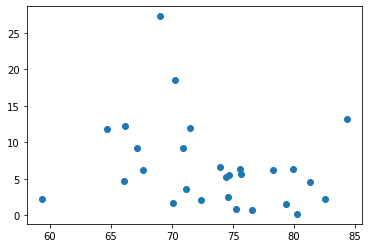

In [142]:
## Scatter
fig, ax = plt.subplots()
ax.scatter(df["propLazy"], df["lazy_diff"])


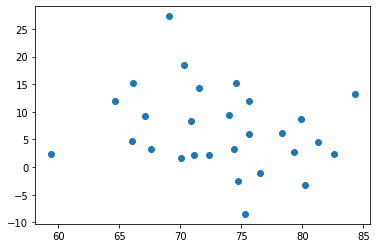

In [149]:
def relax_y_positions(x_vals, y_vals, radius=3, iterations=10):
    y = y_vals.copy()
    for _ in range(iterations):
        for i in range(len(x_vals)):
            for j in range(i + 1, len(x_vals)):
                if abs(x_vals[i] - x_vals[j]) < 1:
                    dy = y[j] - y[i]
                    if abs(dy) < 2 * radius:
                        shift = (2 * radius - abs(dy)) / 2
                        direction = 1 if dy >= 0 else -1
                        y[i] -= shift * direction
                        y[j] += shift * direction
    return y

new_y = relax_y_positions(df["propLazy"], df["lazy_diff"])

## Scatter
fig, ax = plt.subplots()
ax.scatter(df["propLazy"], new_y)